Dataset before after preprocessing: (30000, 24)
Columns with missing values:
 ['Gender', 'Income (USD)', 'Income Stability', 'Type of Employment', 'Current Loan Expenses (USD)', 'Dependents', 'Credit Score', 'Has Active Credit Card', 'Property Age', 'Property Location']

Columns with missing values after handling:
 []


/tmp/ipython-input-1-2491066969.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-1-2491066969.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

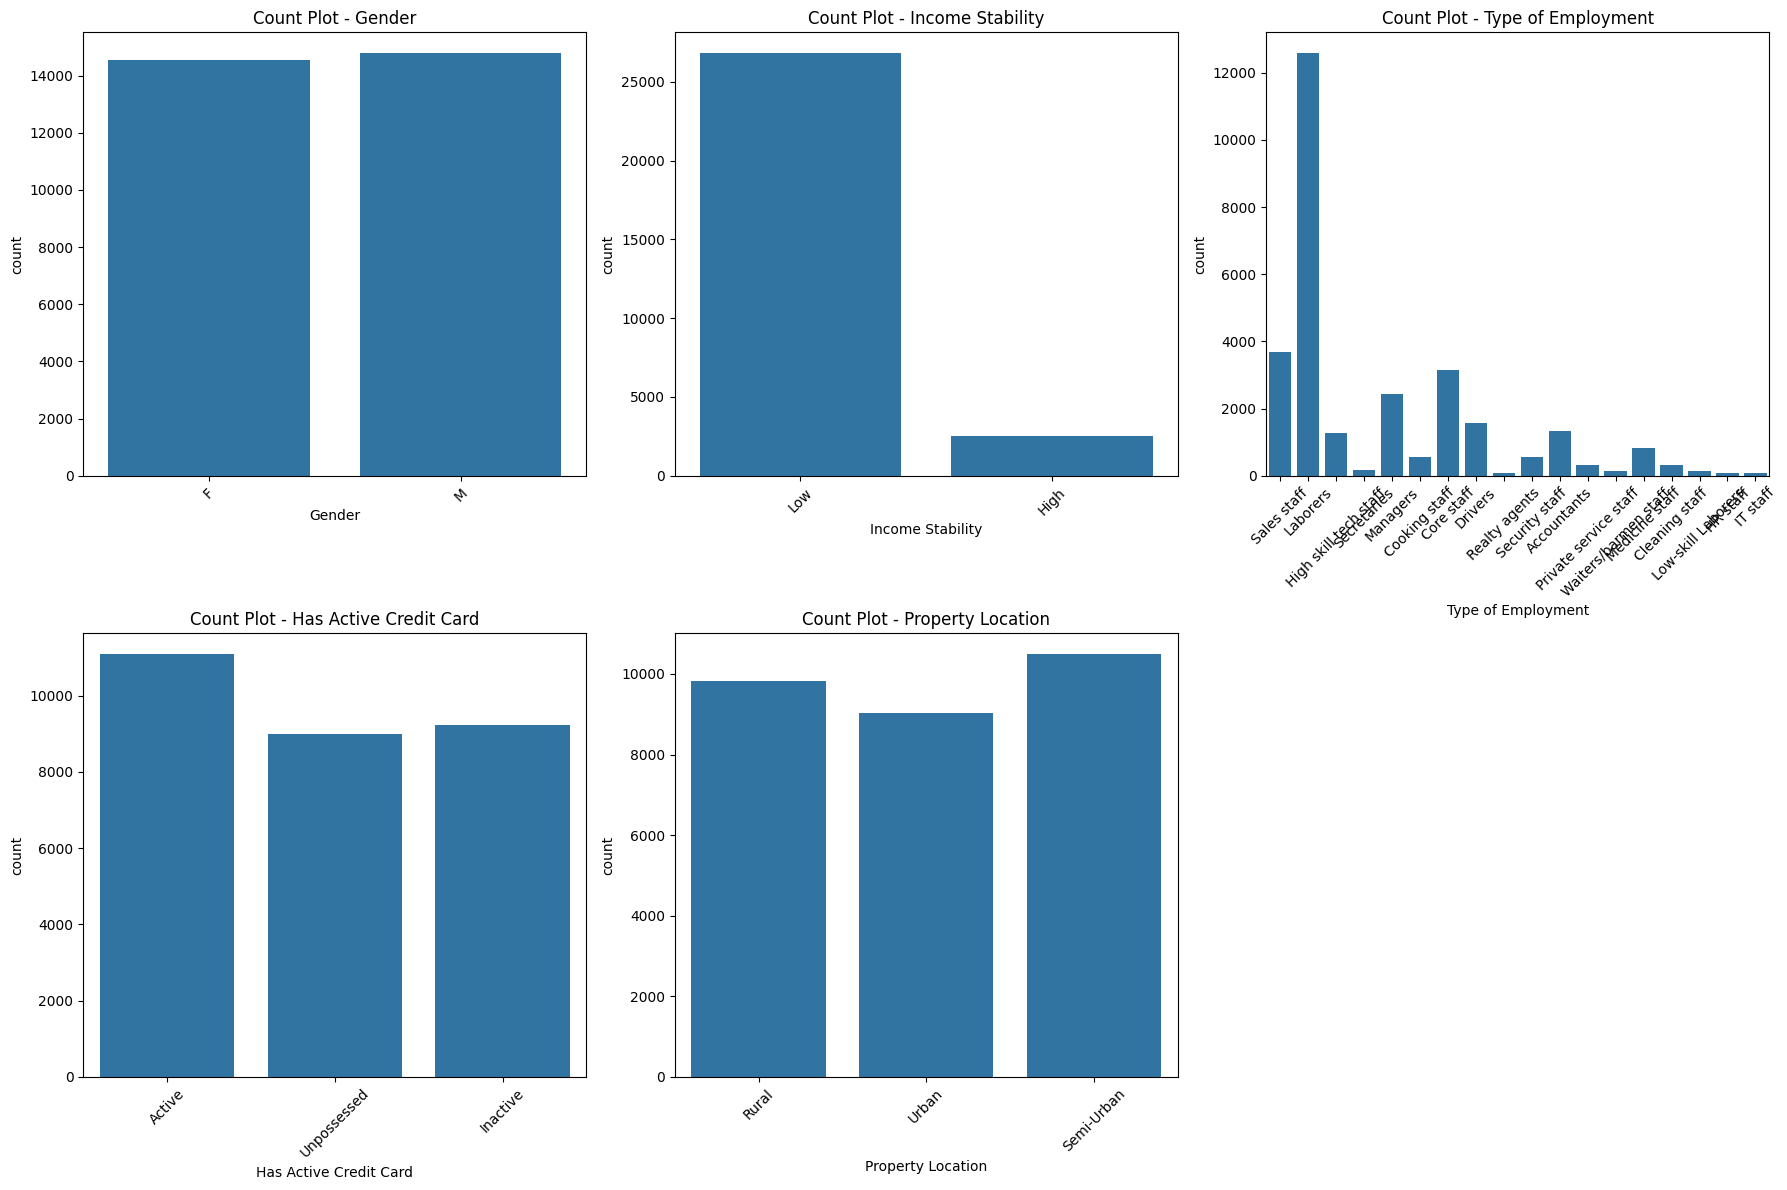

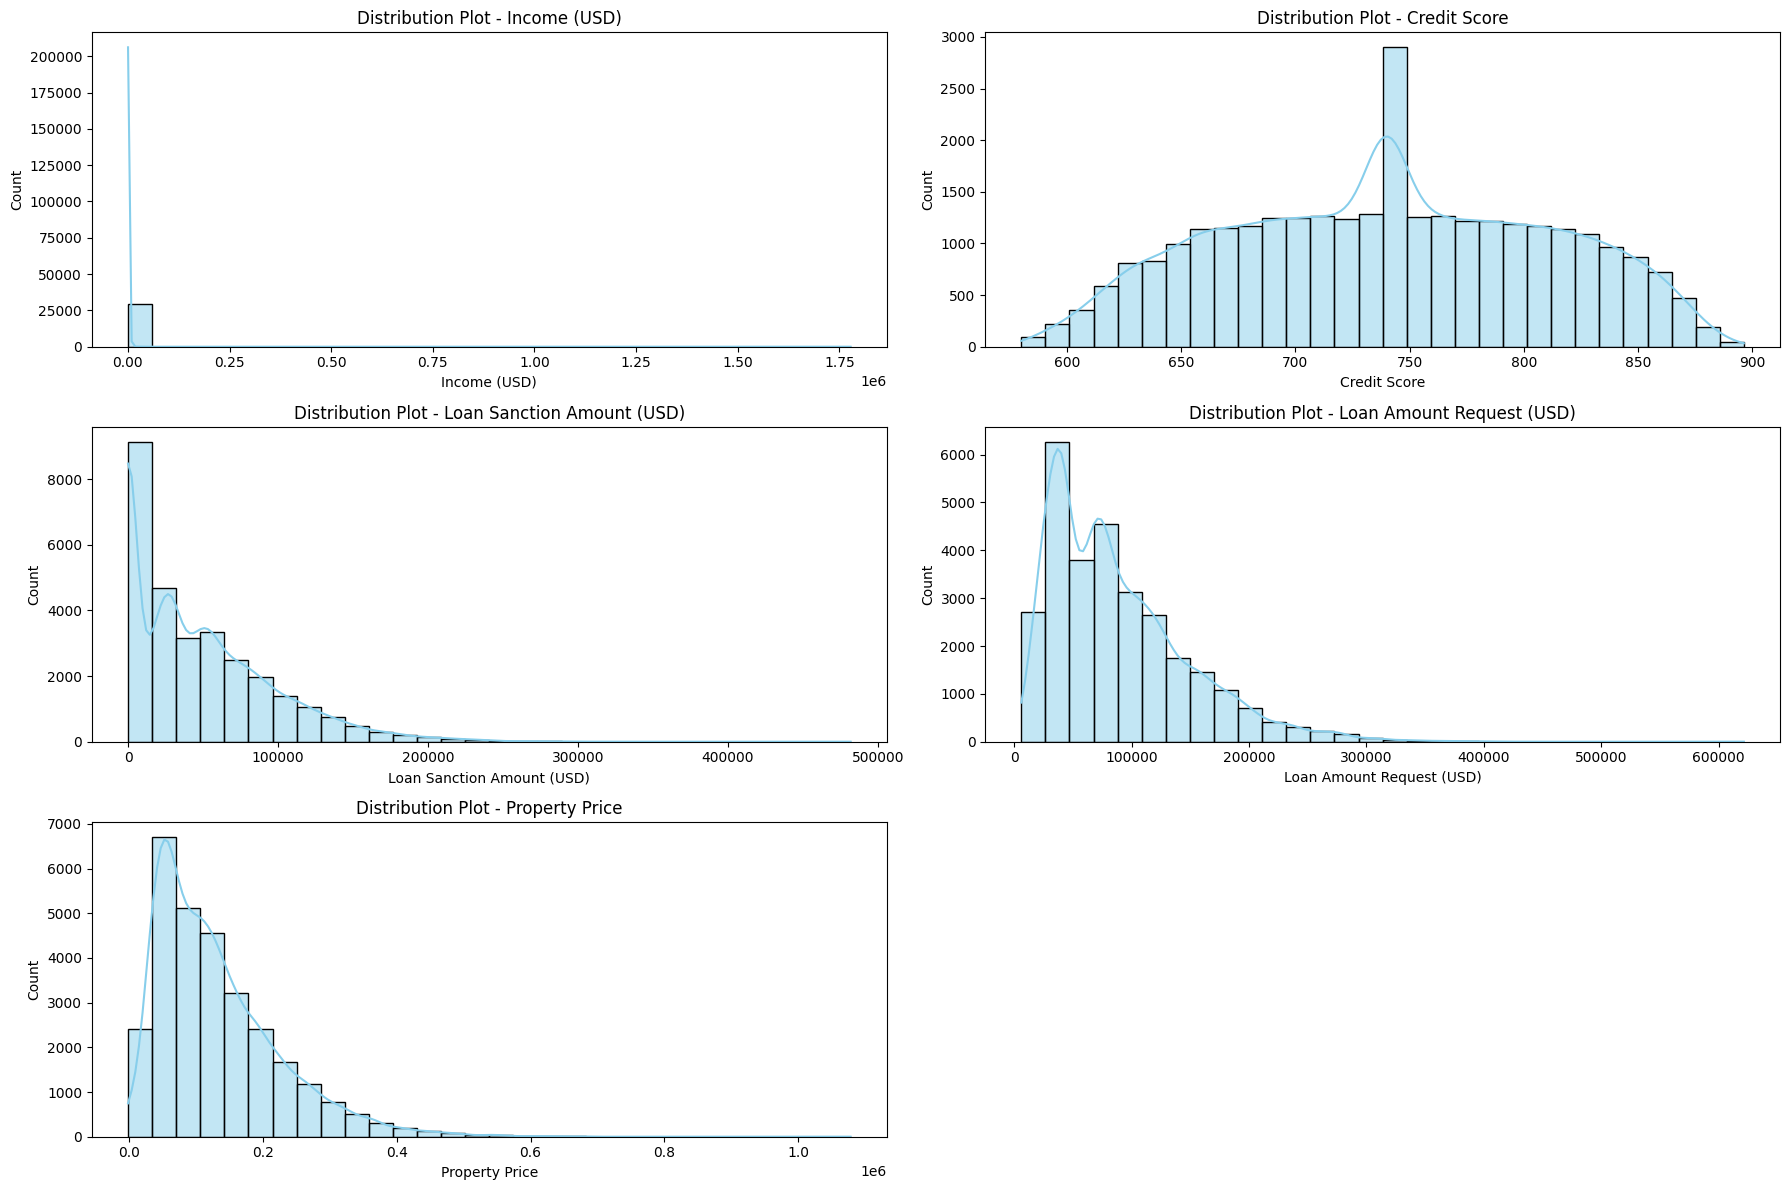

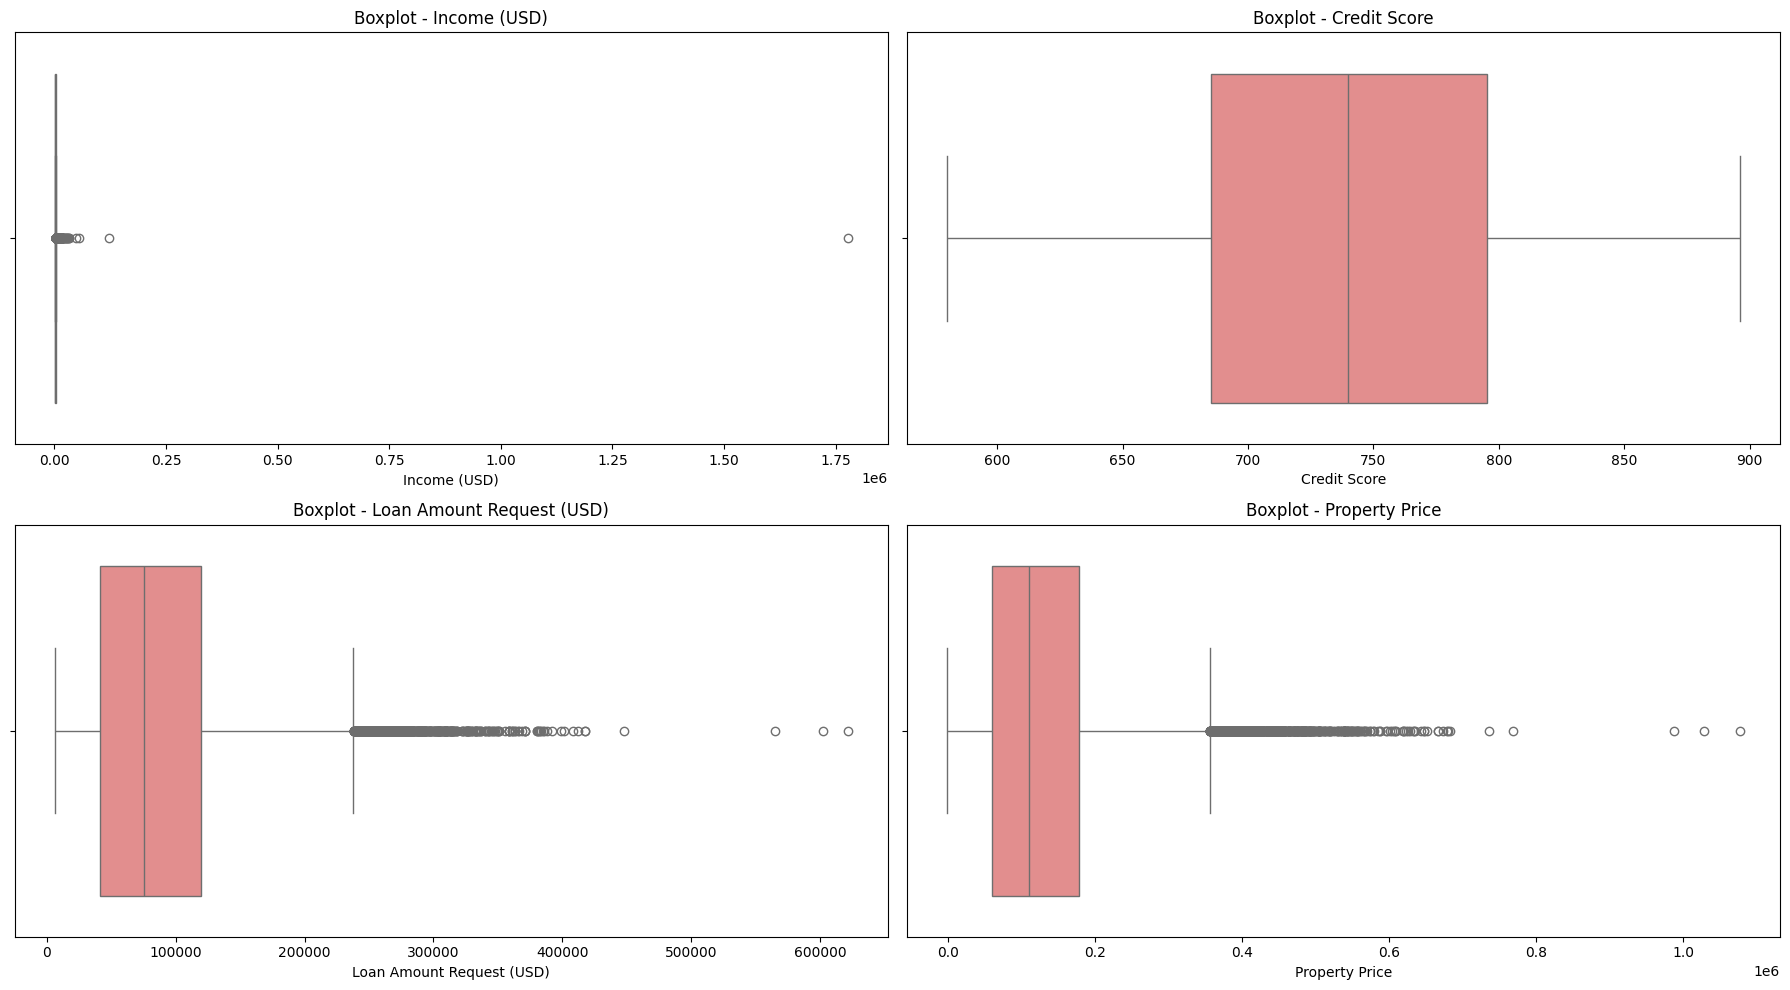

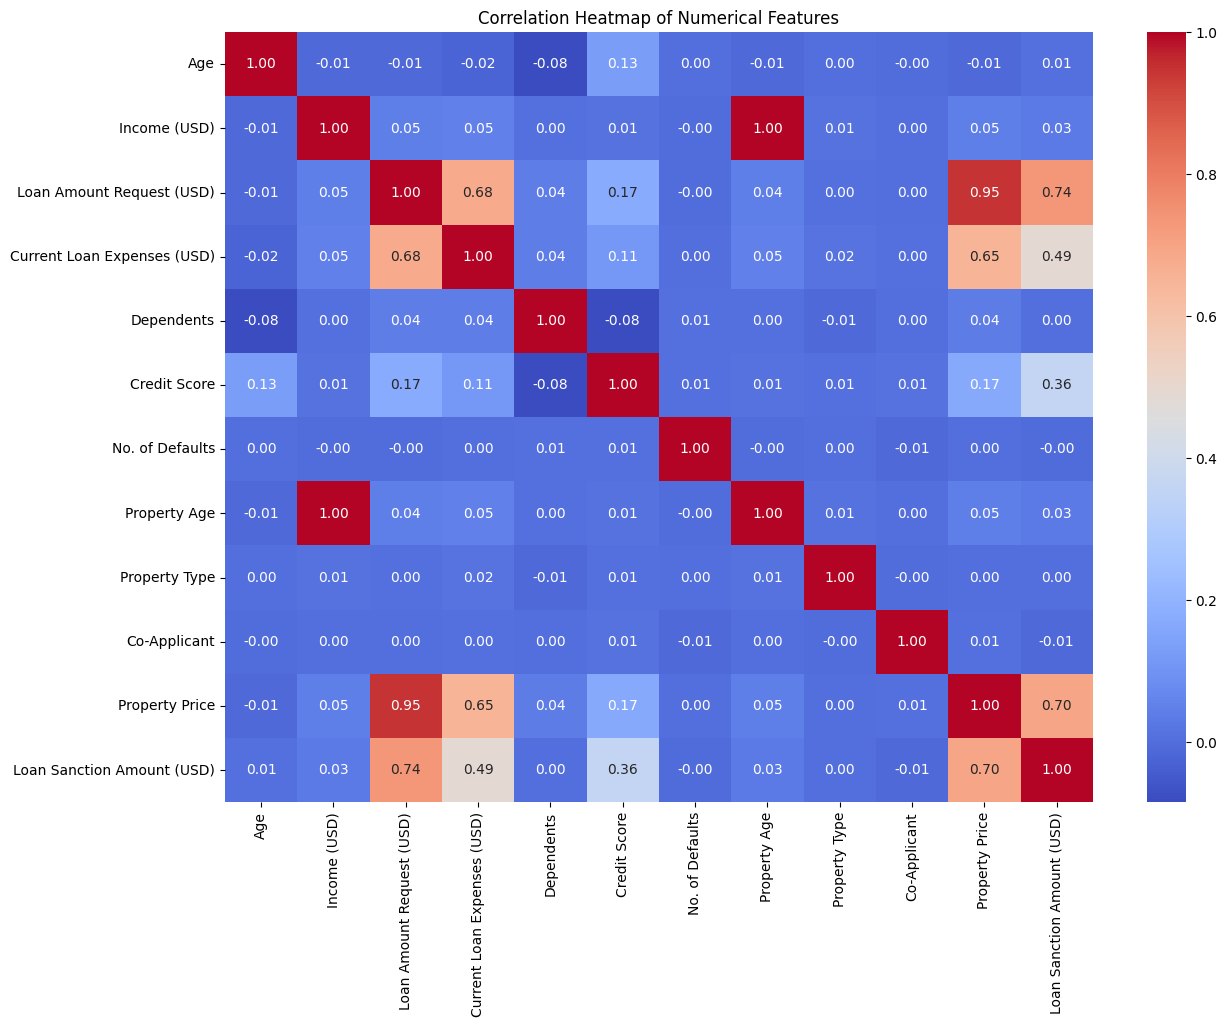

Dataset size after preprocessing: (26388, 21)

=== Validation Set Metrics ===
MAE  : 18756.76
MSE  : 697284864.16
RMSE : 26406.15
R²   : 0.5428
Adj R²: 0.5386

=== Test Set Metrics ===
MAE  : 19267.77
MSE  : 738607232.92
RMSE : 27177.33
R²   : 0.5279
Adj R²: 0.5236


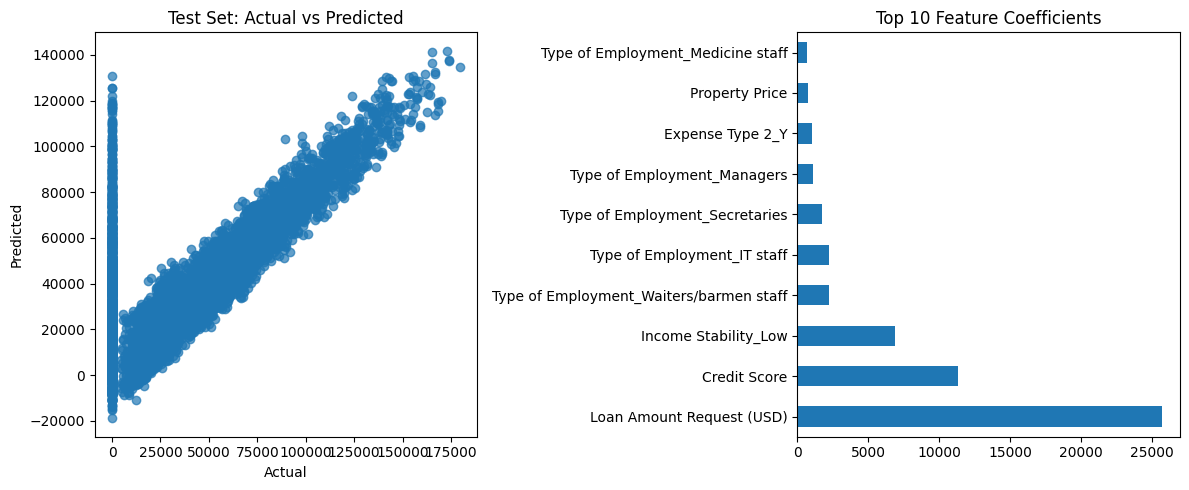

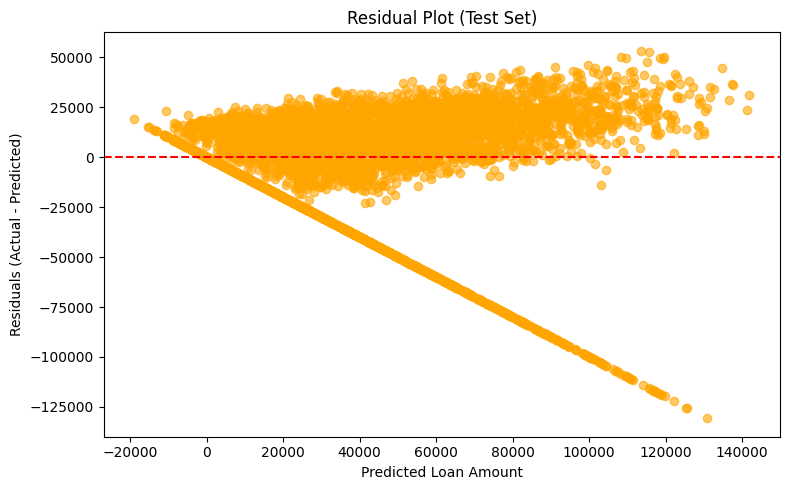


--- Cross Validation Results ---
           Fold           MAE           MSE          RMSE  R2 Score
0        Fold 1  19120.496461  7.138419e+08  26717.820061  0.537610
1        Fold 2  18890.200123  6.845464e+08  26163.837107  0.573006
2        Fold 3  18999.535931  7.028445e+08  26511.215094  0.541468
3        Fold 4  18378.876628  6.749446e+08  25979.695189  0.551025
4        Fold 5  18490.201109  6.508903e+08  25512.552215  0.592046
Average     NaN  18775.862050  6.854135e+08  26177.023933  0.559031


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load dataset
df = pd.read_csv("train.csv")
# Dataset size after preprocessing
print(f"Dataset before after preprocessing: {df.shape}")


# 2. Preprocessing
# Drop irrelevant columns
df.drop(columns=['Customer ID', 'Name', 'Property ID'], inplace=True)

# Remove negative target values
df = df[df['Loan Sanction Amount (USD)'] >= 0]

# Find columns with missing values
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values:\n", missing_cols.tolist())

# Handle missing values
categorical_cols = ['Gender', 'Income Stability', 'Type of Employment', 'Has Active Credit Card', 'Property Location']
numerical_cols = ['Income (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Credit Score', 'Property Age']

# Fill missing categorical values with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with median
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Confirm no missing values
print("\nColumns with missing values after handling:\n", df.columns[df.isnull().any()].tolist())


# 2B. Exploratory Data Analysis (EDA)
import warnings
warnings.filterwarnings('ignore')

# Count plots for categorical features
categorical_features = ['Gender', 'Income Stability', 'Type of Employment', 'Has Active Credit Card', 'Property Location']
plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Count Plot - {col}')
    plt.xticks(rotation=45)
    plt.savefig("count.png")
plt.tight_layout()
plt.show()

# Distribution plots for important numerical features
numerical_features_important = ['Income (USD)', 'Credit Score', 'Loan Sanction Amount (USD)', 'Loan Amount Request (USD)', 'Property Price']
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features_important, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution Plot - {col}')
plt.tight_layout()
plt.show()

# Boxplots before outlier removal
outlier_cols = ['Income (USD)', 'Credit Score', 'Loan Amount Request (USD)', 'Property Price']
plt.figure(figsize=(18, 10))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x=col, color='lightcoral')
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()


# Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# 3. Handle Outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

columns_to_check = ['Income (USD)', 'Credit Score', 'Loan Amount Request (USD)', 'Property Price']
for col in columns_to_check:
    df = remove_outliers_iqr(df, col)

# Dataset size after preprocessing
print(f"Dataset size after preprocessing: {df.shape}")

# 4. One-hot encoding
df = pd.get_dummies(df, columns=[
    'Gender', 'Income Stability', 'Profession', 'Type of Employment',
    'Location', 'Expense Type 1', 'Expense Type 2',
    'Has Active Credit Card', 'Property Type', 'Property Location'
], drop_first=True)

# 5. Feature Engineering
df['Loan_to_Property_Price_Ratio'] = df['Loan Sanction Amount (USD)'] / df['Property Price']

# Fill any remaining NaNs
df.fillna(df.median(numeric_only=True), inplace=True)
# 6. Normalize numerical features
numerical_features = [
    'Age', 'Income (USD)', 'Current Loan Expenses (USD)', 'Dependents',
    'Credit Score', 'Property Age', 'Property Price', 'Loan Amount Request (USD)'
]
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 7. Train/Test/Validation split
X = df.drop('Loan Sanction Amount (USD)', axis=1)
y = df['Loan Sanction Amount (USD)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 8. Train the model
model = LinearRegression()
model.fit(X_train, y_train)


def adjusted_r2(r2, n, k):
    """Calculate Adjusted R² Score."""
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))


# 9. Evaluate the model
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)



# Validation Metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)
val_r2_adj = adjusted_r2(val_r2, X_val.shape[0], X_val.shape[1])

# Test Metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_r2_adj = adjusted_r2(test_r2, X_test.shape[0], X_test.shape[1])

# Print results
print("\n=== Validation Set Metrics ===")
print(f"MAE  : {val_mae:.2f}")
print(f"MSE  : {val_mse:.2f}")
print(f"RMSE : {val_rmse:.2f}")
print(f"R²   : {val_r2:.4f}")
print(f"Adj R²: {val_r2_adj:.4f}")

print("\n=== Test Set Metrics ===")
print(f"MAE  : {test_mae:.2f}")
print(f"MSE  : {test_mse:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R²   : {test_r2:.4f}")
print(f"Adj R²: {test_r2_adj:.4f}")


# 10. Visualizations
plt.figure(figsize=(12, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set: Actual vs Predicted')

# Top Feature Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X.columns)
coefs.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Coefficients')

plt.tight_layout()
plt.show()

# 12. Residual Plot (Test Set)
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='orange')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Loan Amount')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Test Set)')
plt.tight_layout()
plt.savefig("residual_plot.png")  # optional: save the plot
plt.show()


# 11. K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

mae_scores = -cv_results['test_MAE']
mse_scores = -cv_results['test_MSE']
rmse_scores = np.sqrt(mse_scores)
r2_scores = cv_results['test_R2']

cv_table = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(mae_scores))],
    'MAE': mae_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'R2 Score': r2_scores
})
cv_table.loc['Average'] = cv_table.drop(columns='Fold').mean()

print("\n--- Cross Validation Results ---")
print(cv_table)